# Re calibrate ESTIMATEs purity formula

In [23]:
library(TCGAbiolinks)
library(dplyr)
library(DT)
library(ggplot2)
library(patchwork)
library(ggpubr)
library(rstatix)

In [24]:
cancers <- read.table("cancers_valid.tsv") %>%
           rename("cancer"="V1") %>%
           mutate(project=paste("TCGA-",cancer,sep=""))

In [36]:
tcga.purity<-TCGAbiolinks::Tumor.purity %>%
            mutate(CPE=as.numeric(sub(",",".",as.character(CPE))),
                   ESTIMATE=as.numeric(sub(",",".",as.character(ESTIMATE))),
                   ABSOLUTE=as.numeric(sub(",",".",as.character(ABSOLUTE))),
                   LUMP=as.numeric(sub(",",".",as.character(LUMP))),
                   IHC=as.numeric(sub(",",".",as.character(IHC))),
                   patient_id=sub("-0\\d+[A]","",as.character(Sample.ID)),
                   project=paste0("TCGA-",Cancer.type)) %>%
            rename("submitter_id"="Sample.ID",
                  "cancer"="Cancer.type") %>%
            mutate(invESTIMATE=-1*4121.49 + 6812.53*acos(ESTIMATE)) %>%
            filter(!is.na(ESTIMATE))

In [37]:
dim(tcga.purity)

[1] 7737   10

In [38]:
# Purity ESTIMATE
est.purity<-lapply(cancers$cancer,function(cancer){
    est<-data.table::fread(paste("../results/ESTIMATE/",cancer,"_purity_illumina.tsv",sep=""),data.table=F,drop = 2)[c(-1,-2),] %>% t()
    colnames(est)<-est[1,]
    est<-est[-1,] %>%
         as.data.frame() %>%
         rename("submitter_id"="NAME")%>%
         mutate(submitter_id=gsub("\\.","-",submitter_id),
                project = paste0("TCGA-",cancer),
                cancer = cancer) %>%
         mutate(across(StromalScore:ESTIMATEScore,as.numeric),
                TumorPurity=cos(0.6049872018+0.0001467884*ESTIMATEScore))
    return(est)
    }) %>% 
    do.call(rbind,.) %>%
    filter(!is.na(ESTIMATEScore))

In [39]:
dim(est.purity)

[1] 10247     7

In [29]:
purity.full<-full_join(tcga.purity,est.purity)  
dim(purity.full)

Joining, by = c("submitter_id", "cancer", "project")


[1] 7737   14

In [33]:
sum(!est.purity$submitter_id%in%tcga.purity$submitter_id)

[1] 2455

In [34]:
head(purity.full)

,submitter_id,cancer,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,patient_id,project,invESTIMATE,StromalScore,ImmuneScore,ESTIMATEScore,TumorPurity
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TCGA-OR-A5J1-01A,ACC,0.9368,NaN,0.9774,0.80,0.9246,TCGA-OR-A5J1,TCGA-ACC,-1686.5054,17282.05,18777.50,36059.55,0.9267707
2,TCGA-OR-A5J2-01A,ACC,0.9175,NaN,0.6174,0.95,0.8985,TCGA-OR-A5J2,TCGA-ACC,-1334.8402,18733.14,18830.78,37563.92,0.9865411
3,TCGA-OR-A5J3-01A,ACC,0.9670,NaN,0.9249,0.80,0.9466,TCGA-OR-A5J3,TCGA-ACC,-2366.4703,19712.17,19679.92,39392.09,0.9945861
4,TCGA-OR-A5J4-01A,ACC,NaN,NaN,0.9199,0.80,0.8660,TCGA-OR-A5J4,TCGA-ACC,NaN,NA,NA,NA,NA
5,TCGA-OR-A5J5-01A,ACC,0.9761,NaN,1.0000,0.80,0.9780,TCGA-OR-A5J5,TCGA-ACC,-2629.0697,15397.60,16876.71,32274.31,0.5892201
6,TCGA-OR-A5J6-01A,ACC,0.8741,NaN,0.7445,0.88,0.8396,TCGA-OR-A5J6,TCGA-ACC,-666.0628,17910.82,20490.74,38401.56,0.9991475


Warning message:
“Removed 8619 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8624 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8676 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8676 rows containing missing values (`geom_point()`).”


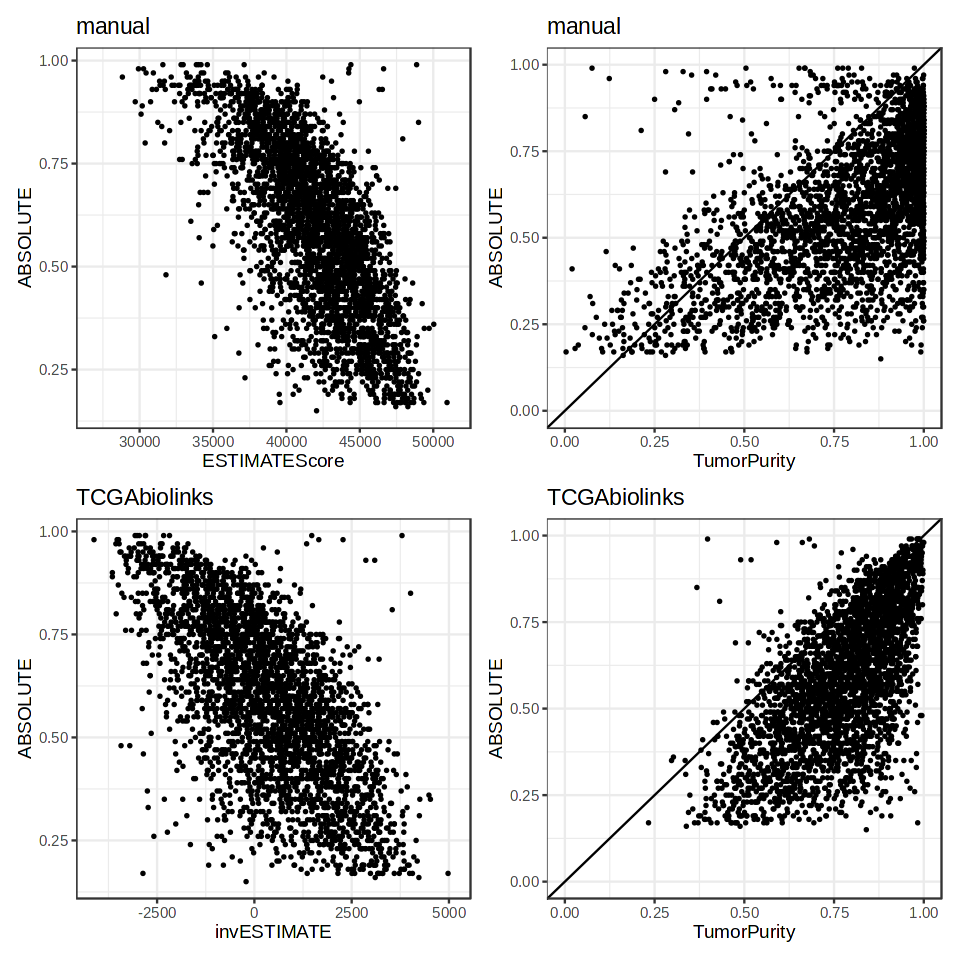

In [11]:
options(repr.plot.height=8,repr.plot.width=8)
p1<-purity.full %>%
    ggplot(.,aes(x=ESTIMATEScore,y=ABSOLUTE))+
    geom_point(size=0.5)+
    theme_bw()+
    geom_abline()+
    labs(xlab="")

p2<-purity.full %>%
    ggplot(.,aes(x=TumorPurity,y=ABSOLUTE))+
    geom_point(size=0.5)+
    theme_bw()+  
    geom_abline()+
    labs(title="manual")+
    xlim(c(0,1))+
    ylim(c(0,1))

p3<-purity.full %>%
    ggplot(.,aes(x=invESTIMATE,y=ABSOLUTE))+
    geom_point(size=0.5)+
    theme_bw()+
    labs(title="TCGAbiolinks")
p4<-purity.full %>%
    ggplot(.,aes(x=ESTIMATE,y=ABSOLUTE))+
    geom_point(size=0.5)+
    theme_bw()+    
    geom_abline()+
    labs(x="TumorPurity",title="TCGAbiolinks")+
    xlim(c(0,1))+
    ylim(c(0,1))

p1+p2+p3+p4

Warning message:
“Removed 1572 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4082 rows containing missing values (`geom_point()`).”


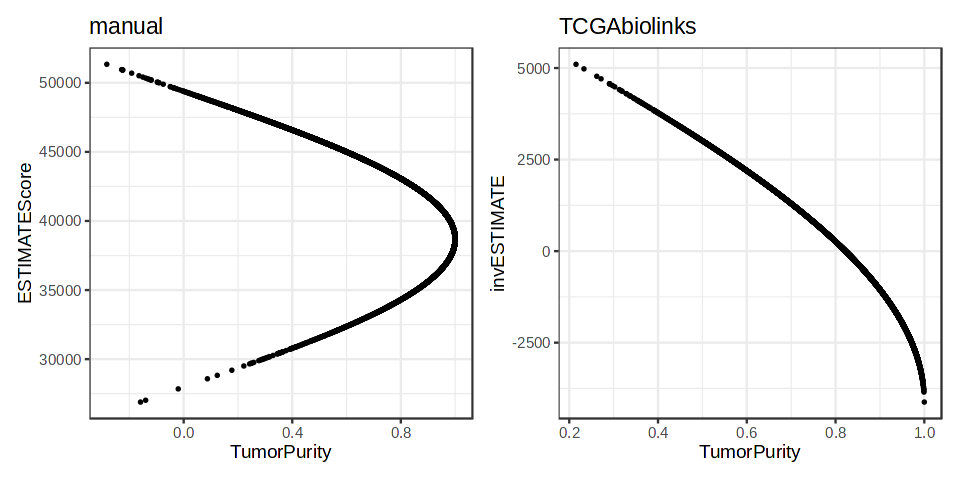

In [12]:
options(repr.plot.width=8,repr.plot.height=4)
p1<-purity.full %>%
    ggplot(.,aes(x=TumorPurity,y=ESTIMATEScore))+
    geom_point(size=0.5)+
    theme_bw()+
    labs(title="manual")
p2<-purity.full %>%
    ggplot(.,aes(x=ESTIMATE,y=invESTIMATE))+
    geom_point(size=0.5)+
    theme_bw()+
    labs(title="TCGAbiolinks",x="TumorPurity")
p1+p2

Warning message:
“Removed 4268 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4255 rows containing missing values (`geom_point()`).”


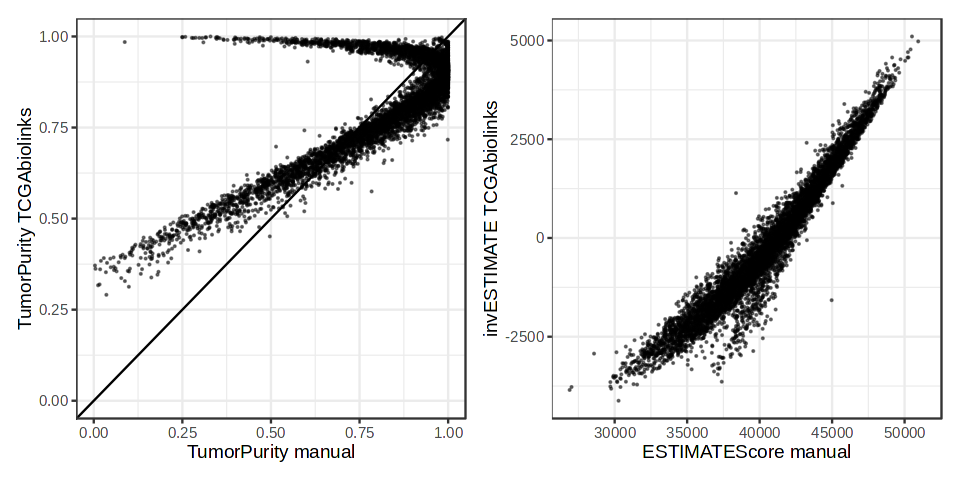

In [13]:
options(repr.plot.height=4,repr.plot.widht=8)
p1<-purity.full %>%
    ggplot(.,aes(x=TumorPurity,y=ESTIMATE))+
    geom_point(size=0.1,alpha=0.5)+
    theme_bw()+
    labs(x="TumorPurity manual",y="TumorPurity TCGAbiolinks")+
    geom_abline()+
    xlim(c(0,1))+
    ylim(c(0,1))
p2<-purity.full %>%
    ggplot(.,aes(x=ESTIMATEScore,y=invESTIMATE))+
    geom_point(size=0.1,alpha=0.5)+
    theme_bw()+
    labs(x="ESTIMATEScore manual",y="invESTIMATE TCGAbiolinks")
p1+p2

# Re-calibarate purity fomrula 

In [14]:
mse <- function(data, par) {
        with(data, sum((cos(par[1]+par[2]*x) - y)^2))
}

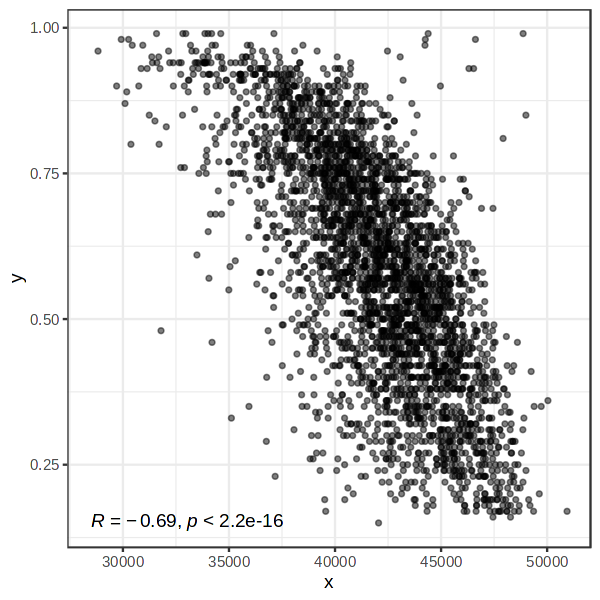

In [15]:
options(repr.plot.height=5,repr.plot.width=5)
p.data<-purity.full %>% 
        select(ABSOLUTE,ESTIMATEScore)  %>% 
        filter(!is.na(ABSOLUTE) & !is.na(ESTIMATEScore))%>% rename("x"="ESTIMATEScore",y="ABSOLUTE")
ggplot(p.data,aes(x,y))+
    geom_point(size=1,alpha=0.5)+
    theme_bw()+
    stat_cor(method = "pearson", label.x = 28500, label.y = 0.15)

In [16]:
init.par<-c(0.6049872018,0.0001467884)
cos.fit<-optim(par=init.par, fn=mse, data=p.data)

In [17]:
cos.fit

$par
[1] 4.974993e+00 5.343217e-05

$value
[1] 65.01255

$counts
function gradient 
     171       NA 

$convergence
[1] 0

$message
NULL

In [18]:
p.data <- p.data %>%
          mutate(fit.y=cos(cos.fit$par[1]+cos.fit$par[2]*x))

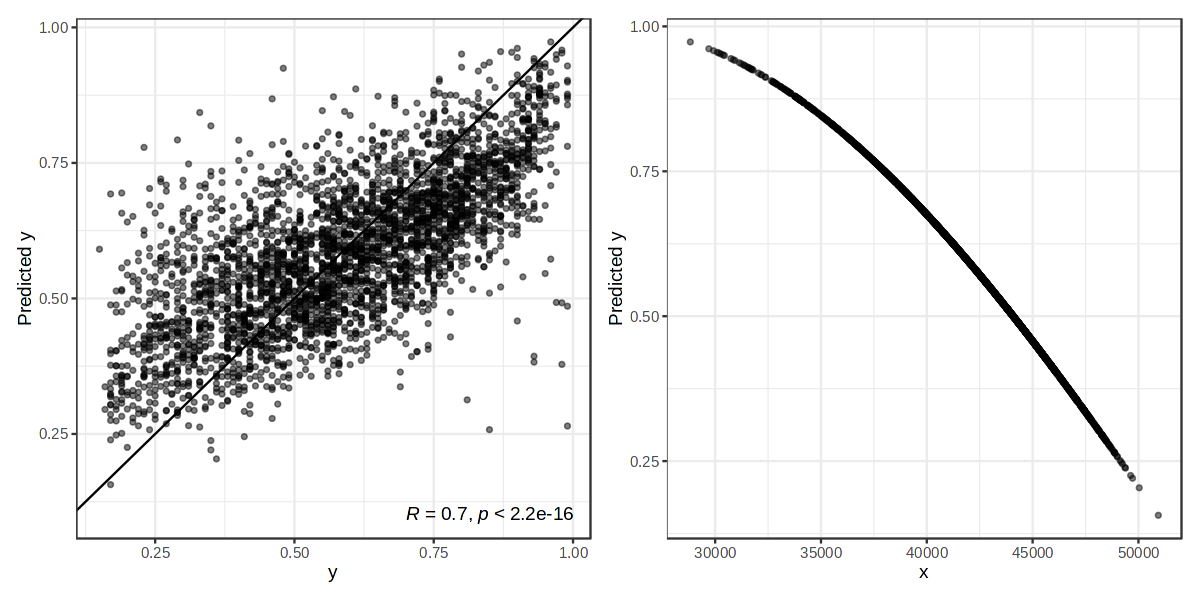

In [19]:
options(repr.plot.height=5,repr.plot.width=10)
p1<-ggplot(p.data,aes(y,fit.y))+
        geom_point(size=1,alpha=0.5)+
        theme_bw()+
        labs(x="y",y="Predicted y")+
        geom_abline()+
        stat_cor(method = "pearson", label.x = 0.7, label.y = 0.1)
p2<-ggplot(p.data,aes(x,fit.y))+
        geom_point(size=1,alpha=0.5)+
        theme_bw()+
        labs(y="Predicted y")+
        geom_abline()
p1+p2

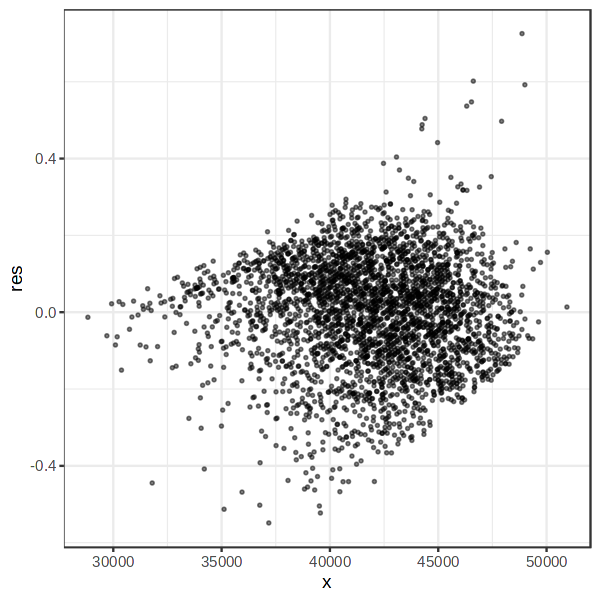

In [20]:
options(repr.plot.height=5,repr.plot.width=5)
p.data %>% 
    mutate(res = y - fit.y) %>%
    ggplot(.,aes(x,res))+
    geom_point(size=0.5,alpha=0.5)+
    theme_bw()

Warning message:
“Removed 4107 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 4107 rows containing missing values (`geom_point()`).”


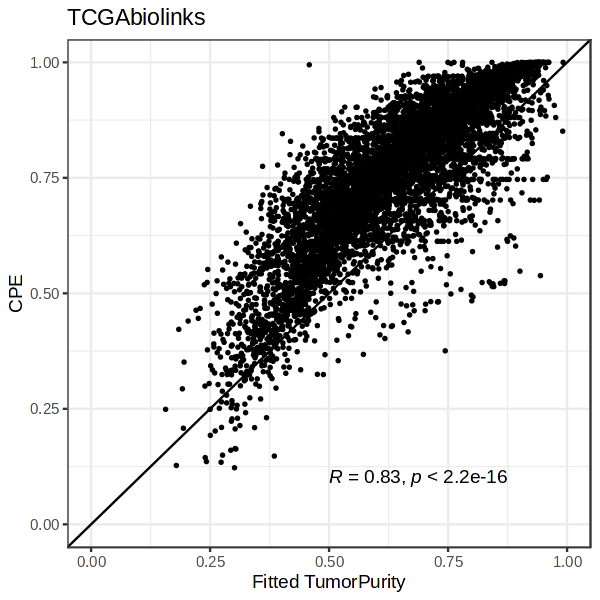

In [21]:
purity.full<-purity.full %>%
             mutate(fit.purity=cos(cos.fit$par[1]+cos.fit$par[2]*ESTIMATEScore))
p4<-purity.full %>%
    ggplot(.,aes(x=fit.purity,y=CPE))+
    geom_point(size=0.5)+
    theme_bw()+    
    geom_abline()+
    labs(x="Fitted TumorPurity",title="TCGAbiolinks")+
    xlim(c(0,1))+
    ylim(c(0,1))+
    stat_cor(method = "pearson", label.x = 0.5, label.y = 0.1)

p4

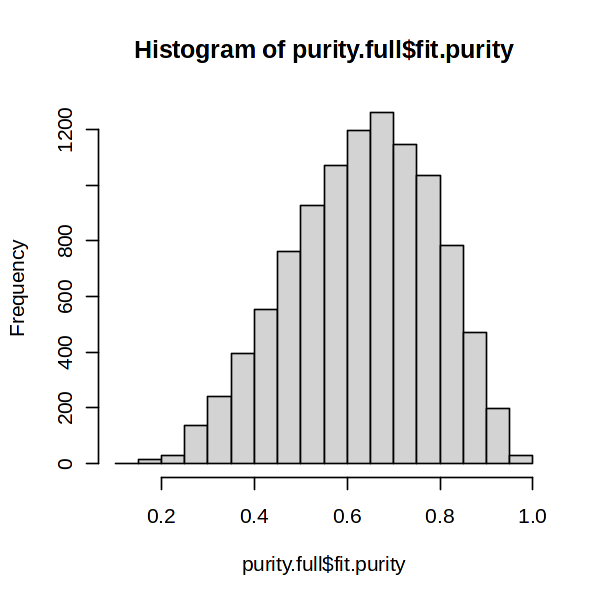

In [117]:
hist(purity.full$fit.purity)

Warning message:
“Removed 1572 rows containing missing values (`geom_point()`).”


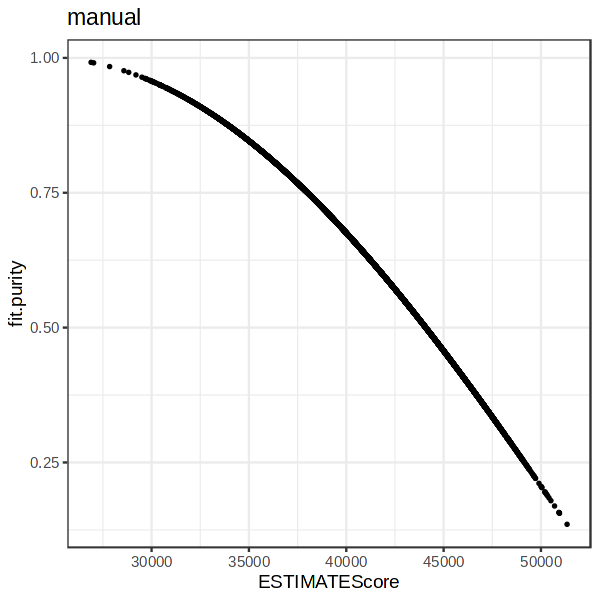

In [22]:
p1<-purity.full %>%
    ggplot(.,aes(x=ESTIMATEScore,y=fit.purity))+
    geom_point(size=0.5)+
    theme_bw()+
    labs(title="manual")
p1